In [1]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

# hyperparameters
hidden_size = 256
learning_rate = 3e-4

# Constants
GAMMA = 0.99
num_steps = 300
max_episodes = 3000

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)
        
        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

In [3]:
def a2c(env):
    num_inputs = env.observation_space.shape[0]
    num_outputs = env.action_space.n
    
    actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
    ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term = 0

    for episode in range(max_episodes):
        log_probs = []
        values = []
        rewards = []

        state = env.reset()
        for steps in range(num_steps):
            value, policy_dist = actor_critic.forward(state)
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy() 

            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, _ = env.step(action)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state
            
            if done or steps == num_steps-1:
                Qval, _ = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy()[0,0]
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))
                if episode % 10 == 0:                    
                    sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
                break
        
        # compute Q values
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + GAMMA * Qval
            Qvals[t] = Qval
  
        #update actor critic
        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)
        
        advantage = Qvals - values
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()

        
    
    # Plot results
    smoothend_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothend_rewards = [elem for elem in smoothend_rewards]
    plt.plot(all_rewards)
    plt.plot(smoothend_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    plt.plot(all_lengths)
    plt.plot(average_lengths)
    plt.xlabel('Episode')
    plt.ylabel('Episode length')
    plt.show()

episode: 0, reward: 25.0, total length: 24, average length: 24.0 
episode: 10, reward: 27.0, total length: 26, average length: 22.8 
episode: 20, reward: 21.0, total length: 20, average length: 25.6 
episode: 30, reward: 10.0, total length: 9, average length: 27.2 
episode: 40, reward: 30.0, total length: 29, average length: 33.0 
episode: 50, reward: 25.0, total length: 24, average length: 24.1 
episode: 60, reward: 50.0, total length: 49, average length: 25.4 
episode: 70, reward: 16.0, total length: 15, average length: 23.5 
episode: 80, reward: 45.0, total length: 44, average length: 23.8 
episode: 90, reward: 50.0, total length: 49, average length: 28.2 
episode: 100, reward: 43.0, total length: 42, average length: 30.3 
episode: 110, reward: 43.0, total length: 42, average length: 29.9 
episode: 120, reward: 10.0, total length: 9, average length: 25.6 
episode: 130, reward: 45.0, total length: 44, average length: 32.5 
episode: 140, reward: 59.0, total length: 58, average length:

episode: 1190, reward: 200.0, total length: 199, average length: 169.7 
episode: 1200, reward: 181.0, total length: 180, average length: 155.4 
episode: 1210, reward: 200.0, total length: 199, average length: 168.1 
episode: 1220, reward: 200.0, total length: 199, average length: 151.5 
episode: 1230, reward: 177.0, total length: 176, average length: 140.7 
episode: 1240, reward: 200.0, total length: 199, average length: 144.7 
episode: 1250, reward: 134.0, total length: 133, average length: 152.9 
episode: 1260, reward: 200.0, total length: 199, average length: 133.9 
episode: 1270, reward: 130.0, total length: 129, average length: 150.7 
episode: 1280, reward: 200.0, total length: 199, average length: 159.3 
episode: 1290, reward: 166.0, total length: 165, average length: 130.7 
episode: 1300, reward: 109.0, total length: 108, average length: 151.2 
episode: 1310, reward: 200.0, total length: 199, average length: 126.2 
episode: 1320, reward: 170.0, total length: 169, average length:

episode: 2330, reward: 190.0, total length: 189, average length: 198.0 
episode: 2340, reward: 165.0, total length: 164, average length: 179.9 
episode: 2350, reward: 200.0, total length: 199, average length: 192.4 
episode: 2360, reward: 200.0, total length: 199, average length: 170.1 
episode: 2370, reward: 200.0, total length: 199, average length: 187.6 
episode: 2380, reward: 142.0, total length: 141, average length: 165.5 
episode: 2390, reward: 142.0, total length: 141, average length: 169.4 
episode: 2400, reward: 200.0, total length: 199, average length: 169.1 
episode: 2410, reward: 190.0, total length: 189, average length: 174.1 
episode: 2420, reward: 200.0, total length: 199, average length: 161.0 
episode: 2430, reward: 188.0, total length: 187, average length: 197.8 
episode: 2440, reward: 102.0, total length: 101, average length: 181.7 
episode: 2450, reward: 200.0, total length: 199, average length: 185.8 
episode: 2460, reward: 200.0, total length: 199, average length:

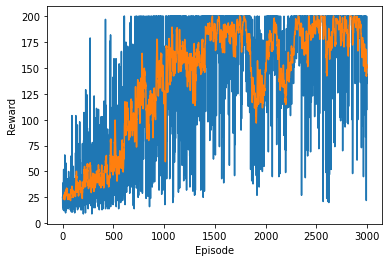

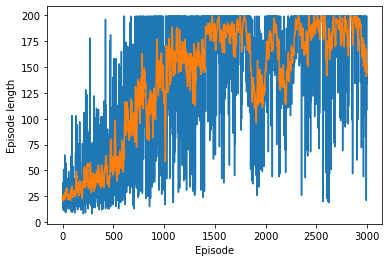

In [4]:
if __name__ == "__main__":
    env = gym.make("CartPole-v0")
    a2c(env) 